- case2: RFCSV feature selection

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import os
import warnings

warnings.filterwarnings("ignore")

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [4]:
n_splits = 3
random_seed = 2025

# Data

In [5]:
train_sleep_file_path = "../data/train/raw/train_sleep.csv"
train_activity_file_path = "../data/train/raw/train_activity.csv"
train_label_file_path = "../data/train/label/1.걸음걸이/training_label.csv"

test_sleep_file_path = "../data/validation/raw/val_sleep.csv"
test_activity_file_path = "../data/validation/raw/val_activity.csv"
test_label_file_path = "../data/validation/label/1.걸음걸이/val_label.csv"

train_derived_file_path = "../data/derived_var/train_add.csv"
test_derived_file_path = "../data/derived_var/validation_add.csv"

train2_derived_file_path = "../data/derived_var/bong_train.csv"
test2_derived_file_path = "../data/derived_var/bong_validation.csv"

train3_derived_file_path = "../data/derived_var/sleep_train_add1.csv"
test3_derived_file_path = "../data/derived_var/sleep_validation_add1.csv"

In [6]:
train_label = pd.read_csv(train_label_file_path)
train_sleep = pd.read_csv(train_sleep_file_path)
train_activity = pd.read_csv(train_activity_file_path)

test_label = pd.read_csv(test_label_file_path)
test_sleep = pd.read_csv(test_sleep_file_path)
test_activity = pd.read_csv(test_activity_file_path)

train_derived = pd.read_csv(train_derived_file_path)
test_derived = pd.read_csv(test_derived_file_path)

train_derived2 = pd.read_csv(train2_derived_file_path)
test_derived2 = pd.read_csv(test2_derived_file_path)
test_derived2.drop(["Unnamed: 0"], inplace=True, axis=1)

train_derived3 = pd.read_csv(train3_derived_file_path)
test_derived3 = pd.read_csv(test3_derived_file_path)

In [7]:
# train, test email exclusive 확인
common_elements = list(
    set(train_label["SAMPLE_EMAIL"]) & set(test_label["SAMPLE_EMAIL"])
)
len(common_elements)

0

In [8]:
# sleep + label
train = train_sleep.merge(train_label, left_on="EMAIL", right_on="SAMPLE_EMAIL")
test = test_sleep.merge(test_label, left_on="EMAIL", right_on="SAMPLE_EMAIL")
train.drop(["SAMPLE_EMAIL"], axis=1, inplace=True)
test.drop(["SAMPLE_EMAIL"], axis=1, inplace=True)

# sleep + activity
train = pd.concat([train, train_activity.drop(["EMAIL"], axis=1)], axis=1)
test = pd.concat([test, test_activity.drop(["EMAIL"], axis=1)], axis=1)

In [9]:
train["activity_date"] = pd.to_datetime(train["activity_day_start"]).dt.date.astype(str)
test["activity_date"] = pd.to_datetime(test["activity_day_start"]).dt.date.astype(str)

In [10]:
train = train.merge(train_derived, on=["EMAIL", "activity_date"], how="inner")
test = test.merge(test_derived, on=["EMAIL", "activity_date"], how="inner")

In [11]:
train = train.merge(train_derived3, on=["EMAIL", "activity_date"], how="inner")
test = test.merge(test_derived3, on=["EMAIL", "activity_date"], how="inner")

In [12]:
train = pd.concat(
    [train, train_derived2.drop(["EMAIL", "activity_day_start"], axis=1)], axis=1
)
test = pd.concat(
    [test, test_derived2.drop(["EMAIL", "activity_day_start"], axis=1)], axis=1
)

In [13]:
for col in train.columns:
    if "_x" in col:
        train.drop([col], axis=1, inplace=True)
        train.rename(
            columns={col.replace("_x", "_y"): col.replace("_x", "")}, inplace=True
        )
    if "avg_" in col:
        train.drop([col], axis=1, inplace=True)
    if "std_" in col:
        train.drop([col], axis=1, inplace=True)

for col in test.columns:
    if "_x" in col:
        test.drop([col], axis=1, inplace=True)
        test.rename(
            columns={col.replace("_x", "_y"): col.replace("_x", "")}, inplace=True
        )
    if "avg_" in col:
        test.drop([col], axis=1, inplace=True)
    if "std_" in col:
        test.drop([col], axis=1, inplace=True)

In [14]:
label_encoder = {"CN": 0, "MCI": 1, "Dem": 2}

In [15]:
train["label"] = train["DIAG_NM"].map(label_encoder)
test["label"] = test["DIAG_NM"].map(label_encoder)
train.drop(["DIAG_NM"], axis=1, inplace=True)
test.drop(["DIAG_NM"], axis=1, inplace=True)

# feature selection

In [16]:
drop_features = [
    "sleep_period_id",
    "sleep_is_longest",
    "sleep_temperature_delta",
    "sleep_temperature_deviation",
]

train_selected = train[train.columns.difference(drop_features)]
test_selected = test[test.columns.difference(drop_features)]

selected_features = [
    col
    for col in train_selected.select_dtypes(include=[int, float]).columns
    if col != "label"
]

selected_features, len(selected_features)  # original = 51

(['abnormal_wake_time',
  'activity_average_met',
  'activity_average_met_30d_avg',
  'activity_average_met_3d_avg',
  'activity_average_met_7d_avg',
  'activity_average_met_lag2',
  'activity_average_met_lag3',
  'activity_cal_active',
  'activity_cal_total',
  'activity_daily_movement',
  'activity_high',
  'activity_inactive',
  'activity_inactive_30d_avg',
  'activity_inactive_3d_avg',
  'activity_inactive_7d_avg',
  'activity_inactive_lag2',
  'activity_inactive_lag3',
  'activity_inactivity_alerts',
  'activity_low',
  'activity_medium',
  'activity_met_min_high',
  'activity_met_min_inactive',
  'activity_met_min_low',
  'activity_met_min_medium',
  'activity_non_wear',
  'activity_rest',
  'activity_score',
  'activity_score_meet_daily_targets',
  'activity_score_move_every_hour',
  'activity_score_recovery_time',
  'activity_score_stay_active',
  'activity_score_training_frequency',
  'activity_score_training_volume',
  'activity_steps',
  'activity_total',
  'awake_interval_a

# 데이터 다운캐스팅

In [17]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2  # 1MB = 1024**2 Byte
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == "object":
            pass
        elif dtype_name == "bool":
            df[col] = df[col].astype("int8")
        elif dtype_name.startswith("int") or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast="integer")
        else:
            df[col] = pd.to_numeric(df[col], downcast="float")
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print("{:.1f}% 압축됨".format(100 * (start_mem - end_mem) / start_mem))

    return df


train = downcast(train)
test = downcast(test)

56.5% 압축됨
56.9% 압축됨


# 데이터 나누기

In [18]:
X_test = test_selected[selected_features]
y_test = test_selected["label"]

In [19]:
train_selected[selected_features].shape, X_test.shape, y_test.shape

((9704, 169), (2478, 169), (2478,))

# Train, Test 데이터 검증

In [20]:
set(train_selected['EMAIL']) & set(test_selected['EMAIL'])

set()

# DIAG_NM(label) 비율

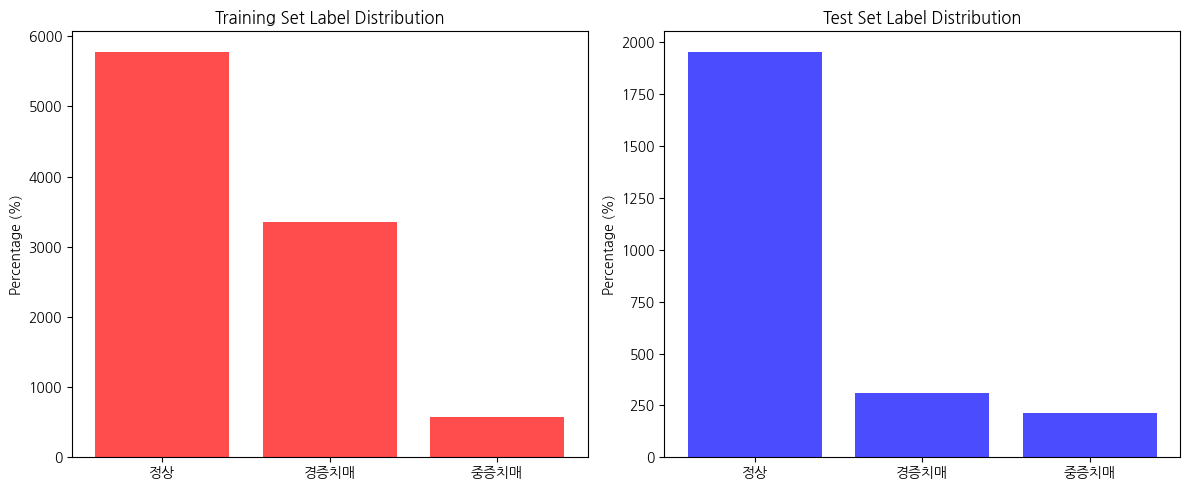

In [21]:
import matplotlib.pyplot as plt

class_distribution_train = train["label"].value_counts()
class_distribution_test = test["label"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(
    class_distribution_train.index,
    class_distribution_train.values,
    color="red",
    alpha=0.7,
)
axes[0].set_xlabel(None)
axes[0].set_ylabel("Percentage (%)")
axes[0].set_title("Training Set Label Distribution")
axes[0].set_xticks([0, 1, 2], ["정상", "경증치매", "중증치매"])

axes[1].bar(
    class_distribution_test.index,
    class_distribution_test.values,
    color="blue",
    alpha=0.7,
)
axes[1].set_xlabel(None)
axes[1].set_ylabel("Percentage (%)")
axes[1].set_title("Test Set Label Distribution")
axes[1].set_xticks([0, 1, 2], ["정상", "경증치매", "중증치매"])

plt.tight_layout()
plt.show()

# 모델 학습 및 성능 검증

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# 모델 학습 및 평가
models = {
    "Lasso Regression": LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr'),
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
}

In [24]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, make_scorer
from sklearn.metrics import accuracy_score, f1_score, classification_report


def evaluate_rfecv_model(
    name, model, train, features, n_splits=n_splits, random_seed=random_seed
):
    acc_scores = []
    f1_scores = []
    class_report_list = []

    # unique EMAIL, label 쌍 추출
    unique_patient_labels = train[["EMAIL", "label"]].drop_duplicates()

    # StratifiedKFold 설정
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

    # RFECV를 적용하여 최적의 피처 선택
    X = train[features]
    y = train["label"]
    
    # 클래스 1(경증치매)의 Recall을 Scoring으로 설정
    scoring = make_scorer(recall_score, labels=[1], average='macro')

    rfecv = RFECV(
        estimator=model,
        step=5,
        cv=skf,
        scoring=scoring,
        min_features_to_select=60,
        n_jobs=-1,
    )
    rfecv.fit(X, y)

    # 선택된 피처 목록
    selected_features = [f for f, keep in zip(features, rfecv.support_) if keep]
    print(f"🔹 Optimal number of features: {rfecv.n_features_}")
    print(f"🔹 Selected Features: {selected_features}")

    for fold_idx, (train_idx, val_idx) in enumerate(
        skf.split(unique_patient_labels["EMAIL"], unique_patient_labels["label"])
    ):
        # 학습/검증 데이터 분리
        train_mask = train["EMAIL"].isin(unique_patient_labels.iloc[train_idx]["EMAIL"])
        val_mask = train["EMAIL"].isin(unique_patient_labels.iloc[val_idx]["EMAIL"])

        X_train, y_train = (
            train.loc[train_mask, selected_features],
            train.loc[train_mask, "label"],
        )
        X_val, y_val = (
            train.loc[val_mask, selected_features],
            train.loc[val_mask, "label"],
        )

        # 모델 학습
        model.fit(X_train, y_train)

        # 모델 예측
        y_pred = model.predict(X_val)

        # 평가 저장
        acc_scores.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average="macro"))

        # Classification Report 저장
        class_report_list.append(
            pd.DataFrame(classification_report(y_val, y_pred, output_dict=True)).T
        )

    # Classification Report 평균
    avg_class_report = pd.concat(class_report_list).groupby(level=0).mean()

    # 평가 결과 출력
    print("#" * 40, f"Model: {name}", "#" * 40)
    print("=== Average Classification Report ===")
    print(avg_class_report)
    print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Average F1-score: {np.mean(f1_scores):.4f}")
    print("=" * 60)

    return name, model, selected_features


# 모델 저장용 딕셔너리
rfecv_models = {}
rfecv_selected_features = {}

# 모델별 RFECV 평가 실행
for name, model in models.items():
    name_, model_, selected_features_ = evaluate_rfecv_model(
        name, model, train, selected_features
    )
    rfecv_models[name] = model_
    rfecv_selected_features[name] = selected_features_

/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3

🔹 Optimal number of features: 124
🔹 Selected Features: ['abnormal_wake_time', 'activity_average_met', 'activity_average_met_30d_avg', 'activity_average_met_lag3', 'activity_cal_active', 'activity_cal_total', 'activity_daily_movement', 'activity_high', 'activity_inactive', 'activity_inactive_30d_avg', 'activity_inactive_3d_avg', 'activity_inactive_7d_avg', 'activity_inactive_lag2', 'activity_inactive_lag3', 'activity_inactivity_alerts', 'activity_low', 'activity_medium', 'activity_met_min_high', 'activity_met_min_inactive', 'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear', 'activity_rest', 'activity_score', 'activity_score_meet_daily_targets', 'activity_score_move_every_hour', 'activity_score_recovery_time', 'activity_score_stay_active', 'activity_score_training_frequency', 'activity_score_training_volume', 'activity_steps', 'activity_total', 'awake_longest_duration', 'awake_longest_duration_30d_avg', 'awake_longest_duration_3d_avg', 'awake_longest_duration_7d_avg'

In [25]:
def learn_model(name, model, train, n_splits=n_splits):
    y_train = train["label"]
    X_train = train[rfecv_selected_features[name]]

    # 모델 학습
    model.fit(X_train, y_train)

    return name, model

for name, model in models.items():
    name_, model_ = learn_model(name, model, train)
    rfecv_models[name] = model_

# Test dataset 예측 결과

In [26]:
# Test Set 성능 평가
print("\n", "=" * 40, "TEST SET EVALUATION", "=" * 40, "\n")

for name, model in rfecv_models.items():
    print(f"=== Evaluating {name} on Test Set ===")

    X_test_selected = X_test[rfecv_selected_features[name]]

    # 테스트 데이터 예측
    y_test_pred = model.predict(X_test_selected)

    # 테스트 데이터 평가
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="macro")  # 불균형 고려
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # 결과 출력
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")
    print(f"Test Classification Report:\n", pd.DataFrame(test_report).T)
    print("=" * 60)


 ======================================== TEST SET EVALUATION ======================================== 

=== Evaluating Lasso Regression on Test Set ===
Test Accuracy: 0.6465
Test F1-score: 0.3965
Test Classification Report:
               precision    recall  f1-score      support
0              0.781379  0.776585  0.778974  1956.000000
1              0.090164  0.142857  0.110553   308.000000
2              0.847826  0.182243  0.300000   214.000000
accuracy       0.646489  0.646489  0.646489     0.646489
macro avg      0.573123  0.367228  0.396509  2478.000000
weighted avg   0.701203  0.646489  0.654529  2478.000000
=== Evaluating Decision Tree on Test Set ===
Test Accuracy: 0.5307
Test F1-score: 0.3757
Test Classification Report:
               precision    recall  f1-score     support
0              0.796907  0.605828  0.688353  1956.00000
1              0.093049  0.269481  0.138333   308.00000
2              0.474747  0.219626  0.300319   214.00000
accuracy       0.530670  0.53067